In [73]:
import sys
sys.path.insert(0,'C:\\code\\masters_thesis\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import requests
import random
import bs4 as bs
import datetime
import yfinance as yf
# from pandas_datareader import data as pdr
# from pandas_datareader.data import DataReader
from pandas_datareader.famafrench import FamaFrenchReader
from pandas_datareader.yahoo.daily import YahooDailyReader
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import minimize
import array_to_latex as a2l

"""
Own packages
"""

# from codelib.statistics.moments import corr_to_cov_matrix
from codelib.population_parameters import calculate_mean, calculate_cov_mat
from codelib.portfolio_measures import portfolio_mean, portfolio_variance, portfolio_std
from codelib.portfolio_performance_measures import sharpe_ratio, calculate_cc_ratio
from codelib.portfolio_optimizers import calculate_max_sharpe_portfolio, calculate_min_var_portfolio, calculate_most_diversified_portfolio

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load datasets

In [2]:
# load datasets (monthly returns for now)

# risky returns
global_equity_returns = pd.read_csv(r'C:\code\masters_thesis\data\10industry_mc_monthly_returnpremiums.csv', index_col='Date')

In [37]:
"""
Initialize values
"""

# number of periods
num_periods = len(global_equity_returns)

# number of factors
num_assets = global_equity_returns.shape[1]

# window size
window_size =  12 * 2 # (2 years of monthly observations)

# effective number of periods
eff_num_periods = num_periods - window_size

# half-life
half_life = 104

# time points
#time_points = np.arange(1, window_size + 1)

# exponential probabilities
#exp_probs = calculate_exponential_decay_probabilities(window_size, time_points, half_life)

# equally weighted portfolio
eq_weights = np.repeat(1.0 / num_assets, num_assets)

# Estimate rolling mu and cov_mat

In [32]:
# estimate rolling mu and cov_mat (optimal weights estimates are replied in next period to calculate out-of-sample returns)
M = 24 # estimation window 24 months

df_mu_rolling = global_equity_returns.rolling(window=M).mean().dropna(inplace=False)
df_cov_mat_rolling = global_equity_returns.rolling(window=M).cov().dropna(inplace=False)

# exponential weighted
# estimation window 5 years halftime 2 years
window_size = 5 * 12 # (5 years of monthly observations not used right no, maybe use span instead for n-day EW moving)
half_life = 2 * 12 # (2 years)
df_exp_mu_rolling = global_equity_returns.ewm(halflife=half_life).mean().dropna(inplace=False).iloc[M-1:,:]
df_exp_cov_mat_rolling = global_equity_returns.ewm(halflife=half_life).cov().dropna(inplace=False).iloc[M-1:,:]

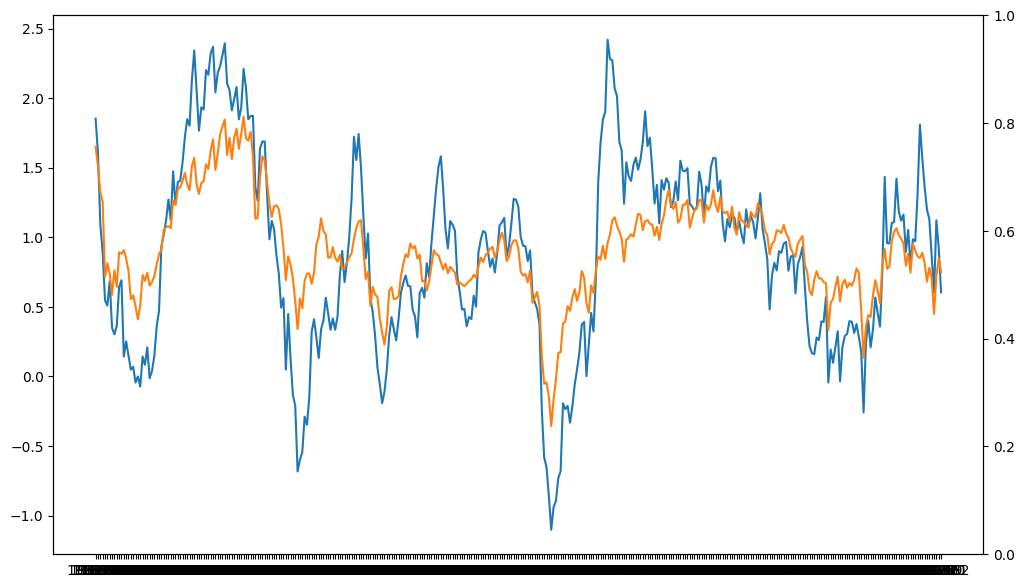

In [34]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(df_mu_rolling.iloc[:,0])
ax.plot(df_exp_mu_rolling.iloc[:,0])

plt.show()

# find optimal weights for each strategy

In [58]:
t = 2
df_cov_mat_rolling.iloc[10*t:10*(1+t),:].values

array([[16.76116793,  6.15154946, 11.39050652,  5.10320435, 11.12056957,
         7.77011087, 15.06187065, 19.81977717,  5.05623696, 11.90543641],
       [ 6.15154946, 38.76086069, 15.25923261,  1.12162754, 17.34781014,
         5.21690797, 10.49696558,  4.12602862, -2.69787319, 14.25051721],
       [11.39050652, 15.25923261, 13.3765913 ,  5.10489565, 12.788     ,
         7.91812609, 12.12612174, 13.98124348,  2.6404913 , 12.57222826],
       [ 5.10320435,  1.12162754,  5.10489565, 15.16202319,  3.25856667,
         8.93277536,  0.60576232,  3.76607536,  6.41367246,  4.27877101],
       [11.12056957, 17.34781014, 12.788     ,  3.25856667, 18.75244928,
         6.03941884, 13.11547971, 13.28467101,  2.18197246, 14.38911014],
       [ 7.77011087,  5.21690797,  7.91812609,  8.93277536,  6.03941884,
        11.89133623,  5.42136667,  8.75398406,  5.84058116,  8.21682536],
       [15.06187065, 10.49696558, 12.12612174,  0.60576232, 13.11547971,
         5.42136667, 18.65512101, 18.69181232

In [82]:
max_sharpe_port_weights = np.zeros((eff_num_periods, num_assets))
most_div_port_weights = np.zeros((eff_num_periods, num_assets))
min_var_port_weights = np.zeros((eff_num_periods, num_assets))

"""
Perform calculations
"""

for t in range(eff_num_periods):

    # covariance matrix
    #cov_mat = calculate_cov_mat(ff_weekly_ret.iloc[t: window_size + t, :].values, probs=exp_probs)

    # max sharpe
    max_sharpe_port_weights[t,:] = calculate_max_sharpe_portfolio(df_mu_rolling.iloc[t,:],df_cov_mat_rolling.iloc[10*t:10*(1+t),:].values,rf=0)
    # most diversified
    most_div_port_weights[t,:] = calculate_most_diversified_portfolio(df_cov_mat_rolling.iloc[10*t:10*(1+t),:].values)
    # minimum variance
    min_var_port_weights[t, :] = calculate_min_var_portfolio(df_cov_mat_rolling.iloc[10*t:10*(1+t),:].values)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7004826233220772
            Iterations: 10
            Function evaluations: 110
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7113689326576029
            Iterations: 9
            Function evaluations: 100
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7156669864657189
            Iterations: 7
            Function evaluations: 78
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7174260961748392
            Iterations: 9
            Function evaluations: 99
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7391590685152416
            Iterations: 7
            Function eva

In [83]:
# store in pandas dataframes
df_max_sharpe_port_weights = pd.DataFrame(data=max_sharpe_port_weights,
                                        index=global_equity_returns[window_size:].index,
                                        columns=global_equity_returns.columns)
df_most_div_port_weights = pd.DataFrame(data=most_div_port_weights,
                                        index=global_equity_returns[window_size:].index,
                                        columns=global_equity_returns.columns)
df_min_var_port_weights = pd.DataFrame(data=min_var_port_weights,
                                        index=global_equity_returns[window_size:].index,
                                        columns=global_equity_returns.columns)

# plot optimal weights

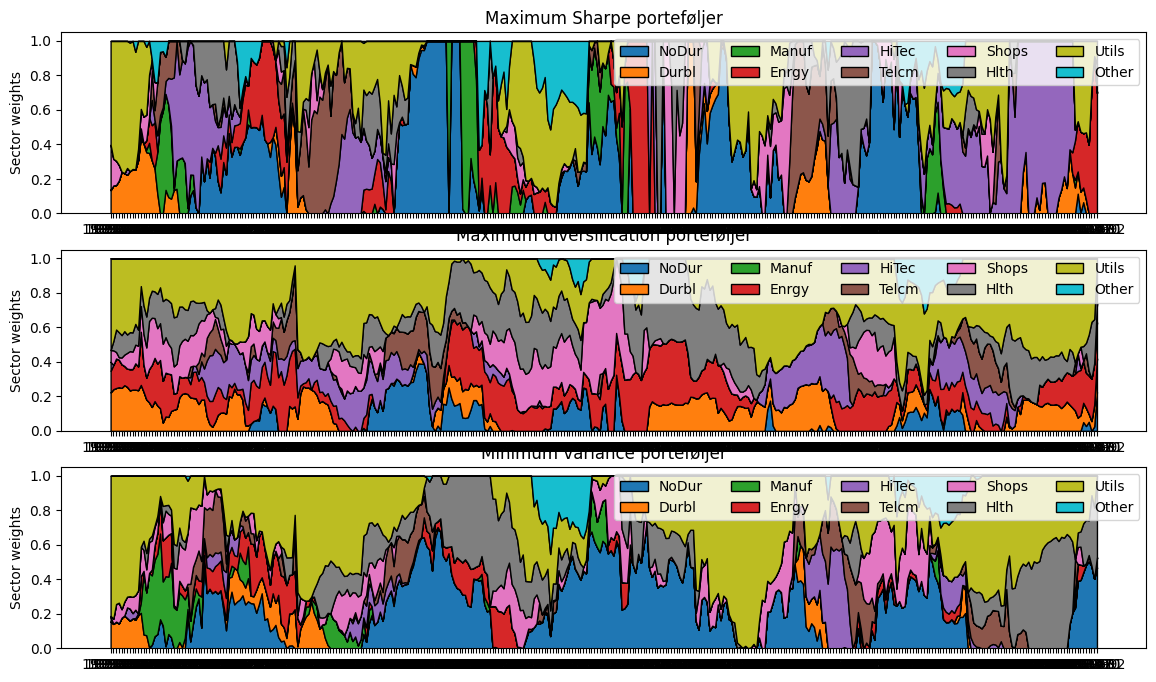

In [90]:
# colors for industries
cmap = plt.get_cmap('jet')
ind_colors = cmap(np.linspace(0, 1, 49))

fig, ax = plt.subplots(3,1,figsize=(14, 8))

ax[0].stackplot(global_equity_returns.index[window_size:],
              max_sharpe_port_weights.T,
              edgecolor="black",
              labels=global_equity_returns.columns)
ax[0].set_ylabel('Sector weights')
ax[0].set_title("Maximum Sharpe porteføljer")
ax[0].legend(ncol=5)

ax[1].stackplot(global_equity_returns.index[window_size:],
              most_div_port_weights.T,
              edgecolor="black",
              labels=global_equity_returns.columns)
ax[1].set_ylabel('Sector weights')
ax[1].set_title("Maximum diversification porteføljer")
ax[1].legend(ncol=5)

ax[2].stackplot(global_equity_returns.index[window_size:],
              min_var_port_weights.T,
              edgecolor="black",
              labels=global_equity_returns.columns)
ax[2].set_ylabel('Sector weights')
ax[2].set_title("Minimum variance porteføljer")
ax[2].legend(ncol=5)

#plt.savefig("rolling_max_sharpe_weights.jpg",bbox_inches="tight",dpi=300)
plt.show()

# Out-of-sample returns

In [96]:
(global_equity_returns[window_size:] * df_min_var_port_weights)

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
1993-01,-4.777367e-14,1.460867e+00,0.000000e+00,7.202378e-14,1.302564e-01,3.547650e-15,6.682627e-04,-7.531074e-13,1.990437,4.064753e-14
1993-02,-6.571064e-14,-3.959788e-02,0.000000e+00,7.324023e-14,-0.000000e+00,0.000000e+00,-4.548060e-02,-4.319630e-13,5.143486,3.081920e-15
1993-03,0.000000e+00,8.428238e-01,1.491694e-17,4.819723e-03,0.000000e+00,1.322010e-15,2.877480e-01,0.000000e+00,1.308154,0.000000e+00
1993-04,-0.000000e+00,3.348352e-01,0.000000e+00,6.982262e-17,-2.849580e-15,-0.000000e+00,-9.747308e-01,1.331995e-15,-0.103009,-4.832072e-16
1993-05,0.000000e+00,1.983098e-01,7.130749e-16,0.000000e+00,0.000000e+00,0.000000e+00,2.927947e-01,0.000000e+00,-0.038653,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...
2022-08,-9.130074e-01,-0.000000e+00,-7.738904e-13,3.140635e-02,-2.007191e-12,-3.498311e-12,-1.705853e-12,-1.275935e+00,0.023022,-2.391696e-13
2022-09,-4.198444e+00,-1.158015e-11,-1.979539e-13,-0.000000e+00,-0.000000e+00,-5.026227e-01,-0.000000e+00,-3.832929e-01,-3.013229,-5.956638e-13
2022-10,4.747142e+00,-1.825437e-12,4.763000e-12,2.563926e-02,2.378057e-13,2.659219e-11,6.599659e-12,3.615120e+00,0.393343,4.135883e-13


In [99]:
(global_equity_returns[window_size:] * df_min_var_port_weights).sum(axis=1)

Date
1993-01    3.582228
1993-02    5.058407
1993-03    2.443545
1993-04   -0.742905
1993-05    0.452452
             ...   
2022-08   -2.134514
2022-09   -8.097588
2022-10    8.781244
2022-11    5.633995
2022-12   -2.411218
Length: 360, dtype: float64

In [126]:
df_port_ret = pd.DataFrame(index=global_equity_returns.index[window_size:])

# monthly return
df_port_ret['min-var'] = (global_equity_returns[window_size:] * df_min_var_port_weights).sum(axis=1)
df_port_ret['most-div'] = (global_equity_returns[window_size:] * df_most_div_port_weights).sum(axis=1)
df_port_ret['max-sharpe'] = (global_equity_returns[window_size:] * df_max_sharpe_port_weights).sum(axis=1)

# total return index
df_port_tri = (1 + df_port_ret/100).cumprod(axis=0)

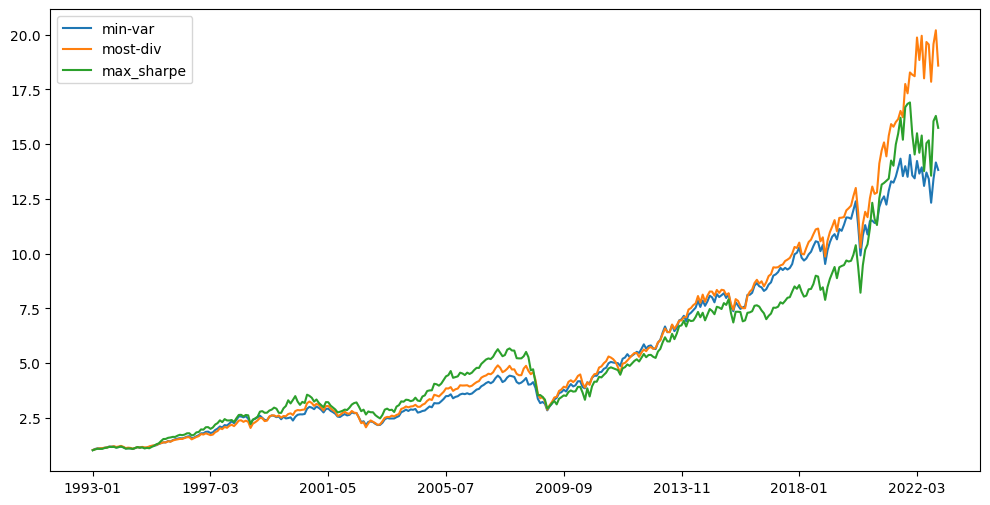

In [101]:
df_port_tri.plot(xlabel="", figsize=(12, 6));

# Portfolio evaluation measures

In [110]:
df_port_tri['min-var']

Date
1993-01     1.035822
1993-02     1.088218
1993-03     1.114810
1993-04     1.106528
1993-05     1.111534
             ...    
2022-08    13.412395
2022-09    12.326314
2022-10    13.408718
2022-11    14.164165
2022-12    13.822636
Name: min-var, Length: 360, dtype: float64

In [116]:
df_port_tri['min-var'][-1]

13.822635729533747

In [130]:
df_port_evaluation_measures = pd.DataFrame(columns=['MV', 'MD', 'MS'])

df_port_evaluation_measures.loc['Arithmetic Avg. return (ann.)', 'MV'] = np.average(df_port_ret['min-var']) * 12 / 100
df_port_evaluation_measures.loc['Arithmetic Avg. return (ann.)', 'MD'] = np.average(df_port_ret['most-div']) * 12 / 100
df_port_evaluation_measures.loc['Arithmetic Avg. return (ann.)', 'MS'] = np.average(df_port_ret['max-sharpe']) * 12 / 100

df_port_evaluation_measures.loc['Geometric Avg. return (ann.)', 'MV'] = df_port_tri['min-var'][-1]**(12 / eff_num_periods) - 1
df_port_evaluation_measures.loc['Geometric Avg. return (ann.)', 'MD'] = df_port_tri['most-div'][-1]**(12 / eff_num_periods) - 1
df_port_evaluation_measures.loc['Geometric Avg. return (ann.)', 'MS'] = df_port_tri['max-sharpe'][-1]**(12 / eff_num_periods) - 1

df_port_evaluation_measures.loc['Volatility (ann.)', 'MV'] = df_port_ret['min-var'].std() * np.sqrt(12) / 100
df_port_evaluation_measures.loc['Volatility (ann.)', 'MD'] = df_port_ret['most-div'].std() * np.sqrt(12) / 100
df_port_evaluation_measures.loc['Volatility (ann.)', 'MS'] = df_port_ret['max-sharpe'].std() * np.sqrt(12) / 100

#sharpe ratio
#max drawdown
#diversification ratio
#turnover


df_port_evaluation_measures

,MV,MD,MS
Arithmetic Avg. return (ann.),0.095591,0.107328,0.104769
Geometric Avg. return (ann.),0.09149,0.102313,0.096234
Volatility (ann.),0.123922,0.137529,0.158424
